In [1]:
import numpy as np 
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
%pylab notebook
# %matplotlib ipympl

Populating the interactive namespace from numpy and matplotlib


In [51]:
 #produce_HSC_image_text_file
idx_group = np.array([16601, 18239, 21880, 23942],dtype = np.int64) - 1 #group id - 1 
zregion = [2.0, 2.4]
print(idx_group.shape)
prod_file = '../data/images/prod_HSC_images_z%s-%s_4grp.txt' %(zregion[0],zregion[1])
with open(prod_file,'w') as f:
    f.write('#? rerun  ra  dec  sw  sh  filter  image  mask  variance  type\n')
    for i in range(idx_group.shape[0]):
        if i == idx_group.shape[0] - 1:
            f.write('  pdr2_dud  '+ str(format(dgroup[idx_group[i],2],'.4f')) + '  ' + str(format(dgroup[idx_group[i],3],'.4f')) + '  0.05  0.05  HSC-I  true   true   false   coadd')
        else:
            f.write('  pdr2_dud  '+ str(format(dgroup[idx_group[i],2],'.4f')) + '  ' + str(format(dgroup[idx_group[i],3],'.4f')) + '  0.05  0.05  HSC-I  true   true   false   coadd\n')

(4,)


In [2]:
'''
column 1: group ID
column 2: richness
column 3: ra
column 4: dec
column 5: redshift
column 6: log M_h/(M_sun/h)
column 7: L_group (10^10Lsun/h/h)
'''
dgroup = np.loadtxt('../odata/CLAUDS_HSC_iband_group')
d2 = np.loadtxt('../odata/iCLAUDS_HSC_iband_2')
digal = np.loadtxt('../odata/CLAUDS_HSC_iband_igal')

In [3]:
'''
plot group images
#------------------
idx_group: idx of group in xxx_group file
path_image: the path to input image file
out_image: the path to output image file
'''

def find_image(zregion,nchoose):
    from astropy.wcs import WCS
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    import glob
    import numpy as np
    
    path_image = '../data/images/HSC_group_z%s-%s_4grp' %(zregion[0],zregion[1])
    filename0 = glob.glob(path_image+'/%s-cutout-HSC-*' %int(nchoose+2))
    print(filename0)
    if len(filename0) < 1:
        print('No this group image')
    image_file = get_pkg_data_filename(filename0[0])
    print(fits.getdata(image_file, ext=0).shape)

    hdu = fits.open(image_file)
    wcs = WCS(hdu[1].header)
    return wcs

def plot_one_group(nclu,nchoose,ax,mapmin,mapmax):
    from astropy.wcs import WCS
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    import glob
    import numpy as np
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    #choose image pathe
    
    #prepare group and member galaxy information
    print("The group id is ", nclu)
    clu_ra = dgroup[nclu-1,2]
    clu_dec = dgroup[nclu-1,3]
    clu_redz = dgroup[nclu-1,4]
    clu_Mh = dgroup[nclu-1,-2].round(2)
    
    idx_gal = np.where(d2[:,0] == nclu)[0]
    galid = np.int64(d2[idx_gal,1])
    ra_gal = digal[galid - 1, 1]
    dec_gal = digal[galid - 1, 2]
    redz_gal = digal[galid - 1, 3].round(2)

    #galaxis around group center
    dra = 0.05
    ddec = 0.05
#     idx_region = np.where((clu_ra > digal[:,1] - dra) & (clu_ra < digal[:,1] + dra) & 
#                           (clu_dec > digal[:,2] - ddec) & (clu_dec < digal[:,2] + ddec))[0] 
    idx_region = np.where((clu_ra > digal[:,1] - dra) & (clu_ra < digal[:,1] + dra) & 
                          (clu_dec > digal[:,2] - ddec) & (clu_dec < digal[:,2] + ddec) &
                         (digal[:,3] >= 1) & (digal[:,3] <= 3))[0] 

    ra_reg = digal[idx_region,1]
    dec_reg = digal[idx_region,2]
    redz_reg = digal[idx_region,3]

    print(ra_reg.shape)

    #prepare group r180 
    import linecache
    fprop = '../odata/CLAUDS_HSC_iband_prop'
    nline = 1+(nclu-1)*6
    gprop = linecache.getline(fprop,nline)
    phyp = [float(prop) for prop in gprop.split()]
    r180 = phyp[-2] #unit:Mpc/h
    
    #=====================================================================
    #begin plot
    path_image = '../data/images/HSC_group_z%s-%s_4grp' %(zregion[0],zregion[1])
    filename0 = glob.glob(path_image+'/%s-*' %int(nchoose+2))
    if len(filename0) <1:
        print('No this group image')
    image_file = get_pkg_data_filename(filename0[0])
    print(fits.getdata(image_file, ext=0).shape)

    hdu = fits.open(image_file)
    ax.imshow(hdu[1].data, cmap = 'Greys', vmax = mapmax, vmin = mapmin, origin='lower')

    #plot center
    cen = wcs.wcs_world2pix(clu_ra, clu_dec, 0)
    ax.plot(cen[0],cen[1],'*',c  = 'r',zorder = 6,label = 'center: $z$ = %s' %clu_redz.round(2))

    #plot around galaxies
    sc2 = ax.scatter(ra_reg, dec_reg, transform=ax.get_transform('world'), s = 20, c = redz_reg,
             cmap = 'jet', zorder = 5, vmin = 1, vmax = 3, alpha = 1, linewidths = 0.6)
    sc2.set_facecolor('none')

#     #set colorbar
#     cax = plt.axes([0.90, 0.12, 0.035, 0.76])
#     fig.colorbar(sc2,cax = cax, shrink = 0.72,label = 'redshift')

    #text redshift 
#     dngrid = 300
#     galreg = wcs.wcs_world2pix(ra_reg, dec_reg, 0)
#     for i in range(ra_reg.shape[0]):
#         if galreg[0][i] > cen[0]-dngrid and galreg[0][i] < cen[0]+dngrid and galreg[1][i] < cen[1]+dngrid and galreg[1][i] > cen[1]-dngrid:
#             plt.text(ra_reg[i]-1e-4, dec_reg[i]+1e-4, str(redz_reg[i].round(2)), fontsize = 6,
#                  transform=ax.get_transform('world'),zorder = 5)

    #plot member galaxy
    ax.plot(ra_gal, dec_gal, 's', transform=ax.get_transform('world'),
            mfc='none',mec= 'r', ms = 6, mew = 0.72, zorder = 5, label = 'members: $N_\mathrm{g}$ = %s' %ra_gal.shape[0])

    #plot group region with r180
    #convert r180 to deg
    from astropy.cosmology import FlatLambdaCDM
    import numpy as np
    cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315)
    d_A = cosmo.comoving_distance(z=clu_redz)
    r180u =  r180 / 0.674 * u.Mpc
    theta_radian = (r180u / d_A).to(u.degree, u.dimensionless_angles()).value # unit is Mpc only now
    print(theta_radian)
    from matplotlib.patches import Circle
    regr180 = Circle((clu_ra, clu_dec), theta_radian, ec='magenta', ls = '--', lw = 1.5, fc='none', zorder = 5,
               transform=ax.get_transform('world'),
                     label = '$r_{180}= %s\ h^{-1}\mathrm{Mpc}$ \n$\mathrm{log} M_\mathrm{h}\ [h^{-1} \mathrm{M_{\odot}]= %s}$' %(np.round(r180,2),np.round(clu_Mh,2)))
    ax.add_patch(regr180)

    #set xlabel
    ax.coords.grid('icrs',color = 'none')
    ax.coords[0].set_axislabel('RA')
    ax.coords[1].set_axislabel('Dec')
    ax.coords[0].set_ticklabel(size="small")
    ax.coords[1].set_ticklabel(size="small")

    lon = ax.coords[0]
    lon.set_major_formatter('d.ddd')
    lat = ax.coords[1]
    lat.set_major_formatter('d.ddd')
    lat.set_ticks_position('l')
    lon.set_ticks_position('b')
    
    ax.set_xlim(cen[0]-350,cen[0]+350)
    ax.set_ylim(cen[1]-350,cen[1]+350)

#     plt.subplots_adjust(bottom=0.02, right=0.88, top=0.98)
    

<IPython.core.display.Javascript object>


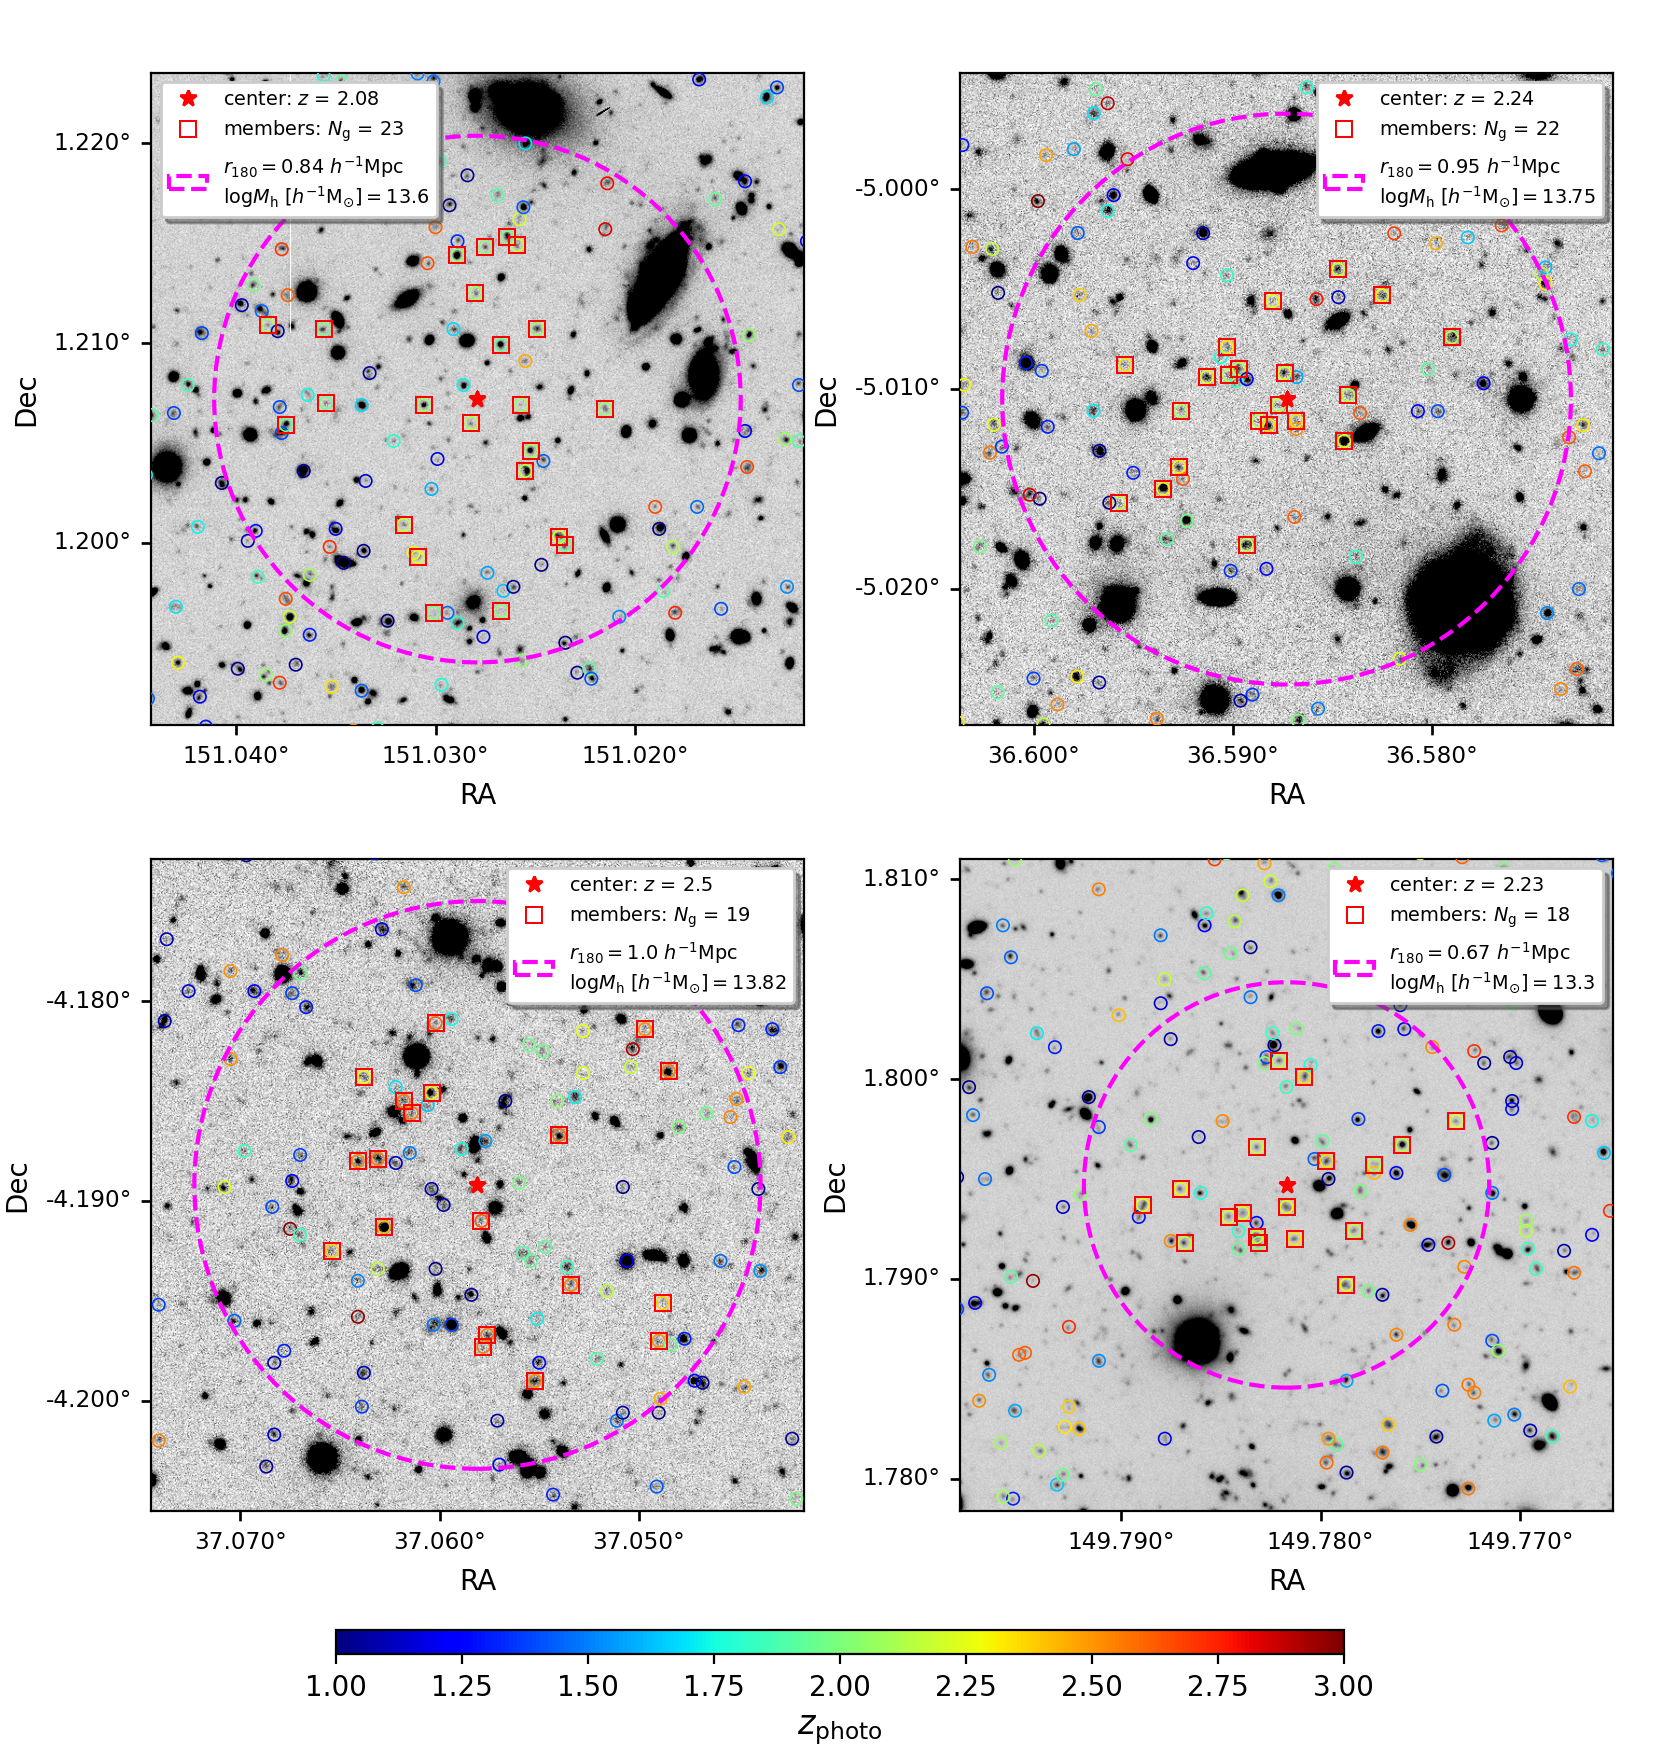

['../data/images/HSC_group_z2.0-2.4_4grp/2-cutout-HSC-I-9571-pdr2_dud.fits']
(2144, 2144)
The group id is  16601
(1199,)
(2144, 2144)
0.013183500339756455
['../data/images/HSC_group_z2.0-2.4_4grp/3-cutout-HSC-I-8525-pdr2_dud.fits']
(2146, 2142)
The group id is  18239
(813,)
(2146, 2142)
0.01428852210993799
['../data/images/HSC_group_z2.0-2.4_4grp/4-cutout-HSC-I-8767-pdr2_dud.fits']
(2145, 2144)
The group id is  21880
(899,)
(2145, 2144)
0.014209561575508805
['../data/images/HSC_group_z2.0-2.4_4grp/5-cutout-HSC-I-9813-pdr2_dud.fits']
(2143, 2145)
The group id is  23942
(1255,)
(2143, 2145)
0.01014697041176189


In [4]:
fig = plt.figure(figsize = (8.4,8.8))

gid = np.array([16601, 18239, 21880, 23942],dtype = np.int64)
zregion = [2.0,2.4]
wcs = find_image(zregion,0)
ax = fig.add_subplot(221,projection=wcs)
mapmax = 0.26; mapmin = -0.1;
plot_one_group(gid[0],0,ax,mapmin,mapmax)
ax.legend(fontsize = 'x-small', loc = 2,shadow = True)

zregion = [2.0,2.4]
wcs = find_image(zregion,1)
ax = fig.add_subplot(222,projection=wcs)
mapmax = 0.25; mapmin = -0.1;
plot_one_group(gid[1],1,ax,mapmin,mapmax)
ax.legend(fontsize = 'x-small', loc = 1,shadow = True)

zregion = [2.0,2.4]
wcs = find_image(zregion,2)
ax = fig.add_subplot(223,projection=wcs)
mapmax = 0.25; mapmin = -0.1;
plot_one_group(gid[2],2,ax,mapmin,mapmax)
ax.legend(fontsize = 'x-small', loc = 1,shadow = True)

zregion = [2.0,2.4]
wcs = find_image(zregion,3)
ax = fig.add_subplot(224,projection=wcs)
mapmax = 0.25; mapmin = -0.1;
plot_one_group(gid[3],3,ax,mapmin,mapmax)
ax.legend(fontsize = 'x-small', loc = 1,shadow = True)

import matplotlib as mpl
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=1, vmax=3)
plt.subplots_adjust(top=0.98,left = 0.09, right = 0.96, bottom = 0.12,hspace = 0.08,wspace = 0.24)
cax = plt.axes([0.2, 0.06, 0.6, 0.014])
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation = 'horizontal')
cbar.set_label(label = '$z_\mathrm{photo}$', fontsize = 12)

plt.show()

plt.savefig('../figs/group_z2.pdf')

In [ ]:
# zregion = [5.6,6.0]; nm = 2;
# #select with redshift and richness
# idx_group = np.where((dgroup[:,4] > zregion[0]) & (dgroup[:,4] <= zregion[1]) & (dgroup[:,1] >= nm))[0]
# print('group id are ', np.int64(dgroup[idx_group,0]))